## Regression with BIWI head pose dataset

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting and converting the data

In [0]:
data_dir = Path(base_dir + 'data')
path = untar_data(URLs.BIWI_HEAD_POSE, dest=data_dir)
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/io_sample.cpp'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/06'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/16.obj'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/01.obj'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/11.obj'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/04.obj'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/14.obj'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/20'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/23'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/24.obj'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/21'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/07'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/biwi_head_pose/18'),
 PosixPath('/con

In [0]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [0]:
fname = '09/frame_00667_rgb.jpg'

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

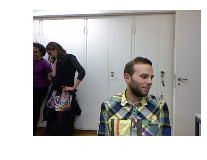

In [8]:
img = open_image(path/fname)
img.show()

In [9]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

In [11]:
get_ctr(fname)

tensor([263.9104, 428.5814])

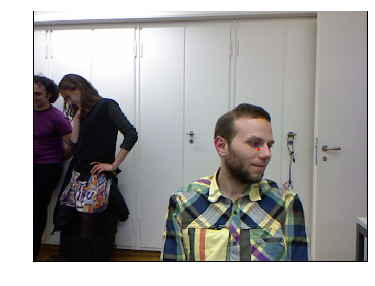

In [12]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

## Creating a dataset

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

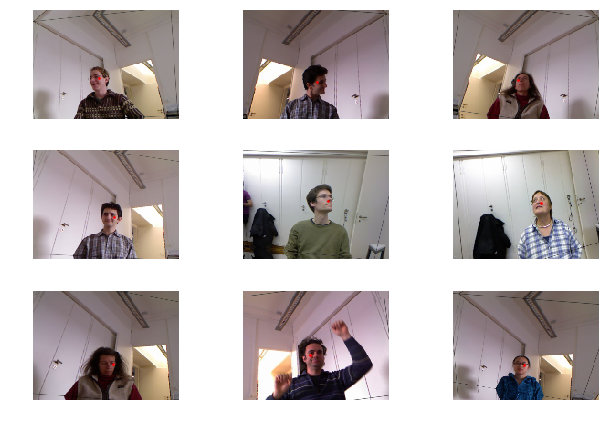

In [16]:
data.show_batch(3, figsize=(9,6))

## Train model

In [17]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 53.4MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


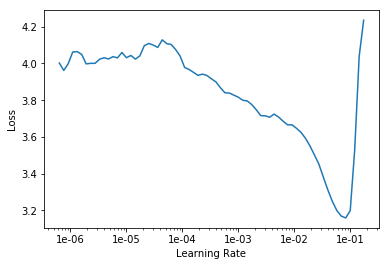

In [18]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 3e-2

In [20]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.140107,0.070612,04:18
1,0.026944,0.005298,04:17
2,0.010716,0.002167,04:17
3,0.006857,0.003102,04:17
4,0.005043,0.001473,04:07


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

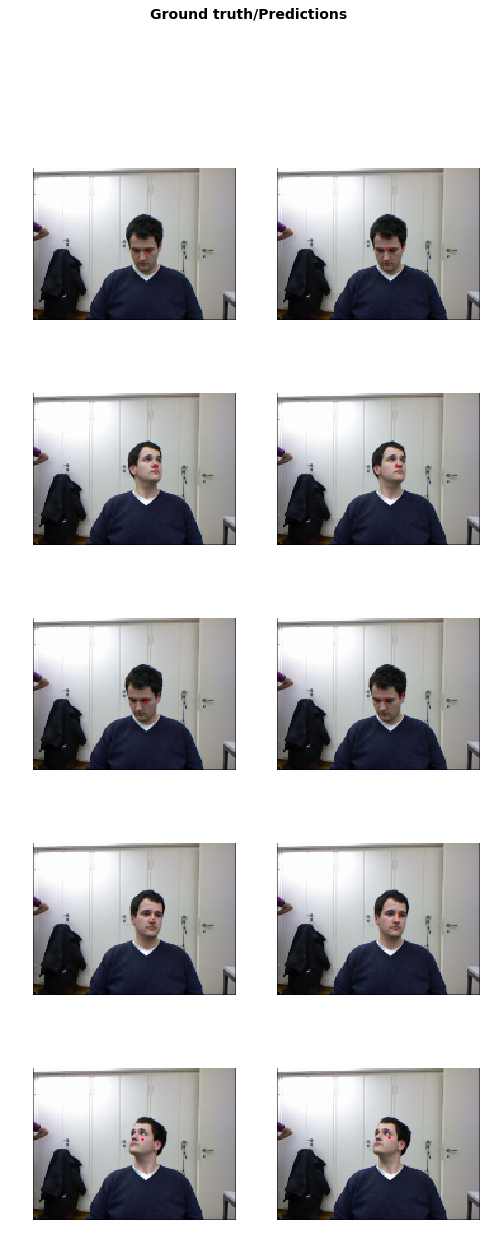

In [23]:
learn.show_results()

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

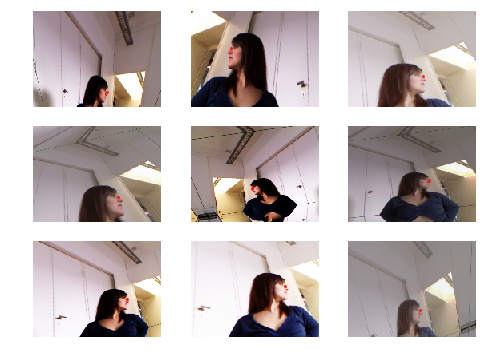

In [25]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))